# Using multi-armed bandits to choose the best model for predicting credit card default

## Dependencies

- [helm](https://github.com/helm/helm)
- [s2i](https://github.com/openshift/source-to-image)

- Kaggle account to download data.
- Python packages:

In [ ]:
!pip install -r requirements.txt

## Getting data

Either head to https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset or use the Kaggle API (instructions at https://github.com/Kaggle/kaggle-api) to download the dataset:

In [ ]:
!kaggle datasets download -d uciml/default-of-credit-card-clients-dataset
!unzip -o default-of-credit-card-clients-dataset.zip

## Load and inspect data

In [36]:
import pandas as pd
data = pd.read_csv('UCI_Credit_Card.csv')

In [37]:
data.shape

(30000, 25)

In [38]:
data.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [39]:
target = 'default.payment.next.month'

In [40]:
data[target].value_counts()

0    23364
1     6636
Name: default.payment.next.month, dtype: int64

Note that we have a class imbalance, so if we use accuracy as the performance measure of a classifier, we need to be able to beat the "dummy" model that classifies every instance as 0 (no default):

In [41]:
data[target].value_counts().max()/data.shape[0]

0.7788

## Case study for using multi-armed bandits

In deploying a new ML model, it is rarely the case that the existing (if any) model is decommissioned immediately in favour of the new one. More commonly the new model is deployed alongside the existing one(s) and the incoming traffic is shared between the models.

Typically A/B testing is performed in which traffic is routed between existing models randomly, this is called the experiment stage. After a set period of time performance statistics are calculated and the best-performing model is chosen to serve 100% of the requests while the other model(s) are decommissioned.

An alternative method is to route traffic dynamically to the best performing model using multi-armed bandits. This avoids the opportunity cost of consistently routing a lot of traffic to the worst performing model(s) during an experiment as in A/B testing.

This notebook is a case study in deploying two models in parallel and routing traffic between them dynamically using multi-armed bandits (Epsilon-greedy and Thompson sampling in particular).

We will use the dataset to simulate a real-world scenario consisting of several steps:

1. Split the data set in half (15K samples in each set) and treat the first half as the only data observes so far
2. Split the first half of the data in proportion 10K:5K samples to use as train:test sets for a first simple model (Random Forest)
3. After training the first model, simulate a "live" environment on the first 5K of data in the second half of the dataset
4. Use the so far observed 20K samples to train a second model (XGBoost)
5. Deploy the second model alongside the first together with a multi-armed bandit and simulate a "live" environment on the last 10K of the unobserved data, routing requests between the two models

The following diagram illustrates the proposed simulation design:

![data-split](assets/split.png)

## Data preparation

In [42]:
import numpy as np
from sklearn.model_selection import train_test_split

OBSERVED_DATA = 15000
TRAIN_1 = 10000
TEST_1 = 5000

REST_DATA = 15000

RUN_DATA = 5000
ROUTE_DATA = 10000

# get features and target
X = data.loc[:, data.columns!=target].values
y = data[target].values

# observed/unobserved split
X_obs, X_rest, y_obs, y_rest = train_test_split(X, y, random_state=1, test_size=REST_DATA)

# observed split into train1/test1
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_obs, y_obs, random_state=1, test_size=TEST_1)

# unobserved split into run/route
X_run, X_route, y_run, y_route = train_test_split(X_rest, y_rest, random_state=1, test_size=ROUTE_DATA)

# observed+run split into train2/test2
X_rest = np.vstack((X_run, X_route))
y_rest = np.hstack((y_run, y_route))

X_train2 = np.vstack((X_train1, X_test1))
X_test2 = X_run

y_train2 = np.hstack((y_train1, y_test1))
y_test2 = y_run

## Model training

We will train both models at once, but defer evaluation of the second model until simulating the live environment.

In [43]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train1, y_train1)

RandomForestClassifier(random_state=1)

Now let's see how good our first model is on the test1 set:

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
f1_score, confusion_matrix, classification_report

In [45]:
y_preds1 = rf.predict(X_test1)

In [46]:
print(classification_report(y_test1, y_preds1,
                           target_names=['No default','Default']))

              precision    recall  f1-score   support

  No default       0.84      0.95      0.89      3927
     Default       0.64      0.36      0.46      1073

    accuracy                           0.82      5000
   macro avg       0.74      0.65      0.68      5000
weighted avg       0.80      0.82      0.80      5000



In [47]:
for score in [accuracy_score, precision_score, recall_score, f1_score, confusion_matrix]:
    print(score.__name__ + ':\n', score(y_test1, y_preds1))

accuracy_score:
 0.82
precision_score:
 0.6444073455759599
recall_score:
 0.3597390493942218
f1_score:
 0.4617224880382775
confusion_matrix:
 [[3714  213]
 [ 687  386]]


Normalized confusion matrix
[[0.94576012 0.05423988]
 [0.64026095 0.35973905]]


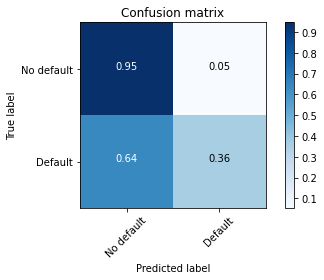

In [48]:
%matplotlib inline
from utils import plot_confusion_matrix

cm = confusion_matrix(y_test1, y_preds1)
plot_confusion_matrix(cm, classes=['No default','Default'], normalize=True)

So a simple random forest model without any optimizations is able to outperform random guessing on accuracy and achieves a baseline F1 score of ~0.44. However, it is a poor predictor of default as it only achieves a recall of ~0.34.

Train the second model in advance, but defer evaluation:

In [50]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=1)
xgb.fit(X_train2, y_train2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [51]:
y_preds1 = xgb.predict(X_test1)

In [52]:
print(classification_report(y_test1, y_preds1,
                           target_names=['No default','Default']))

              precision    recall  f1-score   support

  No default       0.91      0.99      0.95      3927
     Default       0.95      0.64      0.76      1073

    accuracy                           0.92      5000
   macro avg       0.93      0.82      0.86      5000
weighted avg       0.92      0.92      0.91      5000



In [53]:
for score in [accuracy_score, precision_score, recall_score, f1_score, confusion_matrix]:
    print(score.__name__ + ':\n', score(y_test1, y_preds1))

accuracy_score:
 0.9154
precision_score:
 0.9476584022038568
recall_score:
 0.641192917054986
f1_score:
 0.7648693718732629
confusion_matrix:
 [[3889   38]
 [ 385  688]]


Normalized confusion matrix
[[0.9903234  0.0096766 ]
 [0.35880708 0.64119292]]


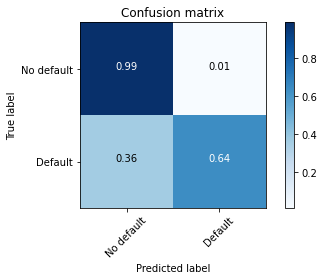

In [54]:
%matplotlib inline
from utils import plot_confusion_matrix

cm = confusion_matrix(y_test1, y_preds1)
plot_confusion_matrix(cm, classes=['No default','Default'], normalize=True)

Save trained models to disk:

In [55]:
import joblib
joblib.dump(rf, 'models/rf_model/RFModel.sav')
joblib.dump(xgb, 'models/xgb_model/XGBModel.sav')

['models/xgb_model/XGBModel.sav']

## Set up Kubernetes for live simulation

Use the setup notebook to [Setup Cluster](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html) to setup Seldon Core with an ingress - either Ambassador or Istio.

Then port-forward to that ingress on localhost:8003 in a separate terminal either with:

 * Ambassador: `kubectl port-forward $(kubectl get pods -n seldon-system -l app.kubernetes.io/name=ambassador -o jsonpath='{.items[0].metadata.name}') -n seldon-system 8003:8080`
 * Istio: `kubectl port-forward $(kubectl get pods -l istio=ingressgateway -n istio-system -o jsonpath='{.items[0].metadata.name}') -n istio-system 8003:80`

### Wrap model and router images with s2i

We have prepared the model classes under ```models/rf_model/RFModel.py``` and ```models/xgb_model/XGBModel.py``` for wrapping the trained models as docker images using s2i. The structure of the files is as follows:

In [ ]:
!pygmentize models/rf_model/RFModel.py

Note that we define our own custom metrics which are the entries of the confusion matrix that will be exposed to Prometheus and visualized in Grafana as the model runs in the simulated live environment.

If Minikube used: create docker image for the trained models and routers inside Minikube using s2i.

## Deploy the first model

In [ ]:
%%writefile rf.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: rf-deployment
spec:
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - image: seldonio/credit_default_rf_model:0.2
          name: rf-model
    graph:
      name: rf-model
      type: MODEL
    name: rf-model
    replicas: 1


In [ ]:
!kubectl apply -f rf.yaml -n seldon

In [ ]:
!kubectl rollout status deploy/$(kubectl get deploy -n seldon -l seldon-deployment-id=rf-deployment -o jsonpath='{.items[0].metadata.name}') -n seldon

## Simulate the first model in production for 5000 samples

In [26]:
from utils import rest_request_ambassador, send_feedback_rest

In [ ]:
for i in range(X_run.shape[0]):
    if i%1000 == 0:
        print(f'Processed {i}/{X_run.shape[0]} samples', flush=True)
        
    # fetch sample and make a request payload
    x = X_run[i].reshape(1,-1).tolist()
    request = {'data':{'ndarray':x}}

    # send request to model
    response = rest_request_ambassador('rf-deployment', 'seldon', request)

    # extract prediction
    probs = response.get('data').get('ndarray')[0]
    pred = np.argmax(probs)

    # send feedback to the model informing it if it made the right decision
    truth_val = int(y_run[i])
    reward = int(pred==truth_val)
    truth = [truth_val]
    _ = send_feedback_rest('rf-deployment', 'seldon', request, response, reward, truth)

Import into grafana the dashbaord in `assets/mab.json`

We can see the model performance on the Grafana dashboard:
http://localhost:3000/d/rs_zGKYiz/mab?refresh=1s&orgId=1&from=now-2m&to=now (refresh to update)

## Deploy the original model and the new model with a router in front

Suppose now we have come up with a new model and want to deploy it alongside the first model with a multi-armed bandit router to make decisions which model should make predictions. We will delete the original deployment and make a new one that has both models in parallel and a router/multi-armed bandit in front.

To make things interesting, we will actually deploy 2 parallel deployments with the same 2 models but a different router in front (Epsilon-greedy and Thompson sampling) to compare the performance of two very different multi-armed bandit algorithms. One can think of the first deployment as a production deployment and the second parallel one as a shadow deployment whose responses are used for testing only.

But first, let's see what the performance of the new XGBoost model is on its test2 data:

In [56]:
y_preds2 = xgb.predict(X_test2)

In [57]:
print(classification_report(y_test2, y_preds2,
                           target_names=['No default','Default']))

              precision    recall  f1-score   support

  No default       0.83      0.94      0.88      3896
     Default       0.60      0.33      0.42      1104

    accuracy                           0.80      5000
   macro avg       0.72      0.63      0.65      5000
weighted avg       0.78      0.80      0.78      5000



In [58]:
for score in [accuracy_score, precision_score, recall_score, f1_score, confusion_matrix]:
    print(score.__name__ + ':\n', score(y_test2, y_preds2))

accuracy_score:
 0.8036
precision_score:
 0.6013289036544851
recall_score:
 0.3278985507246377
f1_score:
 0.4243845252051583
confusion_matrix:
 [[3656  240]
 [ 742  362]]


In [ ]:
cm = confusion_matrix(y_test2, y_preds2)
plot_confusion_matrix(cm, classes=['No default','Default'], normalize=True)

So the XGBoost model is slightly better than the old RFModel, so we expect any decent multi-armed bandit router to pick this up on live data, let's try this out.

First, delete the existing deployment of the old RFModel:

In [ ]:
!kubectl delete sdep rf-deployment

Deploy the following two deployments:

In [20]:
%%writefile eg.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: eg-experiment
spec:
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - image: seldonio/credit_default_rf_model:0.2
          name: rf-model
        - image: seldonio/credit_default_xgb_model:0.2
          name: xgb-model
        - image: seldonio/mab_epsilon_greedy:1.6.0-dev
          name: eg-router
    graph:
      children:
      - name: rf-model
        type: MODEL
      - name: xgb-model
        type: MODEL
      name: eg-router
      parameters:
      - name: n_branches
        type: INT
        value: '2'
      - name: epsilon
        type: FLOAT
        value: '0.1'
      - name: verbose
        type: BOOL
        value: '1'
      - name: branch_names
        type: STRING
        value: rf:xgb
      - name: seed
        type: INT
        value: '1'
      type: ROUTER
    name: eg-2
    replicas: 1
    svcOrchSpec:
      env:
      - name: SELDON_ENABLE_ROUTING_INJECTION
        value: 'true'

Overwriting eg.yaml


In [21]:
%%writefile ts.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: ts-experiment
spec:
  name: poc-ts
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - image: seldonio/credit_default_rf_model:0.2
          name: rf-model
        - image: seldonio/credit_default_xgb_model:0.2
          name: xgb-model
        - image: seldonio/mab_thompson_sampling:1.6.0-dev
          name: ts-router
    graph:
      children:
      - name: rf-model
        type: MODEL
      - name: xgb-model
        type: MODEL
      name: ts-router
      parameters:
      - name: n_branches
        type: INT
        value: '2'
      - name: verbose
        type: BOOL
        value: '1'
      - name: branch_names
        type: STRING
        value: rf:xgb
      - name: seed
        type: INT
        value: '1'
      type: ROUTER
    name: ts-2
    replicas: 1
    svcOrchSpec:
      env:
      - name: SELDON_ENABLE_ROUTING_INJECTION
        value: 'true'

Overwriting ts.yaml


In [22]:
!kubectl apply -f eg.yaml -n seldon
!kubectl apply -f ts.yaml -n seldon

seldondeployment.machinelearning.seldon.io/eg-experiment created
seldondeployment.machinelearning.seldon.io/ts-experiment created


In [23]:
!kubectl rollout status deploy/$(kubectl get deploy -n seldon -l seldon-deployment-id=eg-experiment -o jsonpath='{.items[0].metadata.name}') -n seldon

Waiting for deployment "eg-experiment-eg-2-0-rf-model-xgb-model-eg-router" rollout to finish: 0 of 1 updated replicas are available...
deployment "eg-experiment-eg-2-0-rf-model-xgb-model-eg-router" successfully rolled out


In [24]:
!kubectl rollout status deploy/$(kubectl get deploy -n seldon -l seldon-deployment-id=ts-experiment -o jsonpath='{.items[0].metadata.name}') -n seldon

deployment "ts-experiment-ts-2-0-rf-model-xgb-model-ts-router" successfully rolled out


## Simulate both deployments in parellel with the remaining 10000 data samples

Here we send request and feedback to both parallel deployments, thus assessing the performance of the Epsilon-greedy router versus Thompson sampling as a method of routing to the best performing model.

In [60]:

for i in range(X_route.shape[0]):
    if i%1000 == 0:
        print(f'Processed {i}/{X_route.shape[0]} samples', flush=True)
        
    # fetch sample and make a request payload
    x = X_route[i].reshape(1,-1).tolist()
    request = {'data':{'ndarray':x}}

    # send request to both deployments
    eg_response = rest_request_ambassador('eg-experiment', 'seldon', request)
    ts_response = rest_request_ambassador('ts-experiment', 'seldon', request)
    
    # extract predictions
    eg_probs = eg_response.get('data').get('ndarray')[0]
    ts_probs = ts_response.get('data').get('ndarray')[0]
    eg_pred = np.argmax(eg_probs)
    ts_pred = np.argmax(ts_probs)

    # send feedback to the model informing it if it made the right decision
    truth_val = int(y_route[i])
    eg_reward = int(eg_pred==truth_val)
    ts_reward = int(ts_pred==truth_val)
    truth = [truth_val]
    
    _ = send_feedback_rest('eg-experiment', 'seldon', request, eg_response, eg_reward, truth)
    _ = send_feedback_rest('ts-experiment', 'seldon', request, ts_response, ts_reward, truth)

Processed 0/10000 samples
Processed 1000/10000 samples
Processed 2000/10000 samples
Processed 3000/10000 samples
Processed 4000/10000 samples
Processed 5000/10000 samples
Processed 6000/10000 samples
Processed 7000/10000 samples
Processed 8000/10000 samples
Processed 9000/10000 samples


We can see the model performance on the Grafana dashboard:
http://localhost:3000/dashboard/db/mab?refresh=5s&orgId=1 (refresh to update)

We note that both the Epsilon greedy and Thompson sampling allocate more traffic to the better performing model (XGBoost) over time, but Thompson Sampling does so at a quicker rate as evidenced by the superior metrics (F1 score in particular).

## Clean-up

In [ ]:
# delete data
!rm default-of-credit-card-clients-dataset.zip
!rm UCI_Credit_Card.csv

# delete trained models
!rm models/rf_model/RFModel.sav
!rm models/xgb_model/XGBModel.sav

# delete Seldon deployment from the cluster
!kubectl delete sdep --all